In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import ee
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.std import tqdm

import agrigee_lite as agl


In [3]:
ee.Initialize(opt_url="https://earthengine-highvolume.googleapis.com", project="ee-mateuspsilva")

In [4]:
s2_sat = agl.sat.Sentinel2(use_sr=False)
l8_sat = agl.sat.Landsat8(use_sr=False)
sat = agl.sat.UnifiedSatellite(s2_sat, l8_sat)

In [25]:
gdf = gpd.read_parquet("data/mt_crops.parquet")
gdf["start_date"] = pd.to_datetime(gdf.year.apply(lambda x: f"{x-1}-10-01"))
gdf["end_date"] = pd.to_datetime(gdf.year.apply(lambda x: f"{x}-10-01"))
gdf = gdf[(gdf.start_date>= sat.startDate) & (gdf.end_date <= sat.endDate)].reset_index(drop=True)

In [26]:
df = agl.get.multiple_sits(gdf.sample(3000, random_state=42).reset_index(drop=True), sat)

Simplifying clusters: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


In [28]:
df = df[(df.nirs2>0.025) & (df.nirl8>0.025)].reset_index(drop=True) # Filtro hard de nuvem

In [ ]:
df.indexnum

/home/mateus/git/AgriGEE.lite/.venv/lib/python3.11/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,indexnum,timestamp,bluel8,greenl8,redl8,nirl8,swir1l8,swir2l8,blues2,greens2,reds2,re1s2,re2s2,re3s2,nirs2,re4s2,swir1s2,swir2s2,validPixelsCount
0,1,2021-11-27,0.127075,0.129883,0.128418,0.371582,0.369629,0.205933,0.132324,0.139771,0.147949,0.177856,0.279297,0.335938,0.310791,0.379883,0.372803,0.213501,763.0
1,1,2022-05-06,0.094299,0.074951,0.048157,0.419189,0.147827,0.050171,0.085815,0.074585,0.046112,0.064697,0.234009,0.382324,0.352783,0.426025,0.155151,0.052704,2486.0
2,1,2022-07-25,0.127563,0.133545,0.176392,0.321533,0.432617,0.272949,0.123474,0.130005,0.182251,0.197388,0.226196,0.262207,0.267090,0.317139,0.429199,0.269043,2750.0
3,3,2021-08-16,0.104187,0.091003,0.108032,0.188843,0.318604,0.212402,0.100647,0.091492,0.114136,0.123779,0.140991,0.161865,0.164673,0.189697,0.327393,0.220703,413.0
4,7,2019-12-08,0.099731,0.081177,0.047516,0.700684,0.264893,0.096130,0.144897,0.130859,0.103394,0.127563,0.426270,0.616211,0.560059,0.661133,0.270020,0.119873,170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7680,2997,2018-07-23,0.118591,0.121094,0.162476,0.305176,0.402832,0.248535,0.117004,0.120239,0.170410,0.190918,0.221558,0.252686,0.266846,0.304688,0.407959,0.252197,817.0
7681,2998,2023-02-23,0.124451,0.101868,0.102356,0.140503,0.149414,0.092163,0.133789,0.130493,0.159668,0.164673,0.187012,0.215942,0.200806,0.240845,0.320557,0.196167,10768.0
7682,2998,2023-05-14,0.086121,0.072571,0.042450,0.562012,0.178223,0.059662,0.085693,0.079102,0.044067,0.084839,0.389893,0.550293,0.517090,0.587891,0.197876,0.066589,17984.0
7683,2998,2023-08-02,0.099854,0.079651,0.071594,0.318604,0.188843,0.084229,0.100525,0.085327,0.078674,0.107605,0.227295,0.286865,0.284180,0.332764,0.213257,0.098328,17984.0


In [ ]:
X_columns = ['bluel8', 'greenl8', 'redl8', 'nirl8', 'swir1l8', 'swir2l8']
y_columns = ['blues2', 'greens2', 'reds2', 're1s2', 're2s2', 're3s2', 'nirs2', 're4s2', 'swir1s2', 'swir2s2']

X = df[X_columns].astype(np.float32)
y = df[y_columns].astype(np.float32)
groups = df.indexnum

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=len(X_columns))),  # ou n_components=0.95 se quiser redução
    ('regressor', LinearRegression())
])

n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

r2_scores = []

for train_idx, val_idx in gkf.split(X, y, groups=groups):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)

    r2 = r2_score(y_val, y_pred, multioutput='uniform_average')
    r2_scores.append(r2)


print(f"R² médio: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

R² médio: 0.8909 ± 0.0060


In [22]:
groups

,indexnum,indexnum
0,0,1
1,1,1
2,2,1
3,3,3
4,4,7
...,...,...
7680,7680,2997
7681,7681,2998
7682,7682,2998
7683,7683,2998


In [ ]:
for train_idx, val_idx in gkf.split(X, y, groups=groups):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

TypeError: GroupKFold.split() missing 1 required positional argument: 'X'

In [21]:
groups

,indexnum,indexnum
0,0,1
1,1,1
2,2,1
3,3,3
4,4,7
...,...,...
7680,7680,2997
7681,7681,2998
7682,7682,2998
7683,7683,2998


In [8]:
print(len(df))

7685


In [9]:
# Configurações
common_bands = ["blue", "green", "red", "nir", "swir1", "swir2"]
X_cols = [f"{band}l8" for band in common_bands]
group_col = "indexnum"
n_splits = 5
colors = {
    "red": "red", "green": "green", "blue": "blue",
    "nir": "purple", "swir1": "orange", "swir2": "brown"
}

# Modelos a testar
model_dict = {
    "LinearRegression": LinearRegression(),
}

# Armazenamento
all_results = {}   # y_true e y_pred
all_models = {}    # últimos modelos treinados
fold_metrics = []

for model_name, base_model in tqdm(model_dict.items()):
    all_results[model_name] = {}
    all_models[model_name] = {}

    for band in common_bands:
        y_col = f"{band}s2"

        X = df[X_cols].astype(np.float32)
        y = df[y_col].astype(np.float32)
        groups = df[group_col]

        kf = GroupKFold(n_splits=n_splits)

        fold_preds = []
        fold_truth = []
        fold_models = []

        for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X, y, groups=groups)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            model = base_model.__class__(**base_model.get_params())
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            # Salvar métricas do fold
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            rmse = root_mean_squared_error(y_test, y_pred)

            fold_preds.append(y_pred)
            fold_truth.append(y_test.to_numpy())
            fold_models.append(model)
            fold_metrics.append({
                "fold": fold_idx,
                "model": model_name,
                "band": band,
                "r2": r2,
                "mae": mae,
                "rmse": rmse
            })

        # Salvar último modelo
        all_models[model_name][band] = fold_models[-1]

        all_results[model_name][band] = {
            "y_true": np.concatenate(fold_truth),
            "y_pred": np.concatenate(fold_preds)
        }

# Comparação com Landsat x Sentinel (dados reais, sem modelo)
all_results["Landsat-Sentinel"] = {}
for band in common_bands:
    all_results["Landsat-Sentinel"][band] = {
        "y_true": df[f"{band}s2"].astype(np.float32).values,
        "y_pred": df[f"{band}l8"].astype(np.float32).values
    }

metrics_df = pd.DataFrame(fold_metrics)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


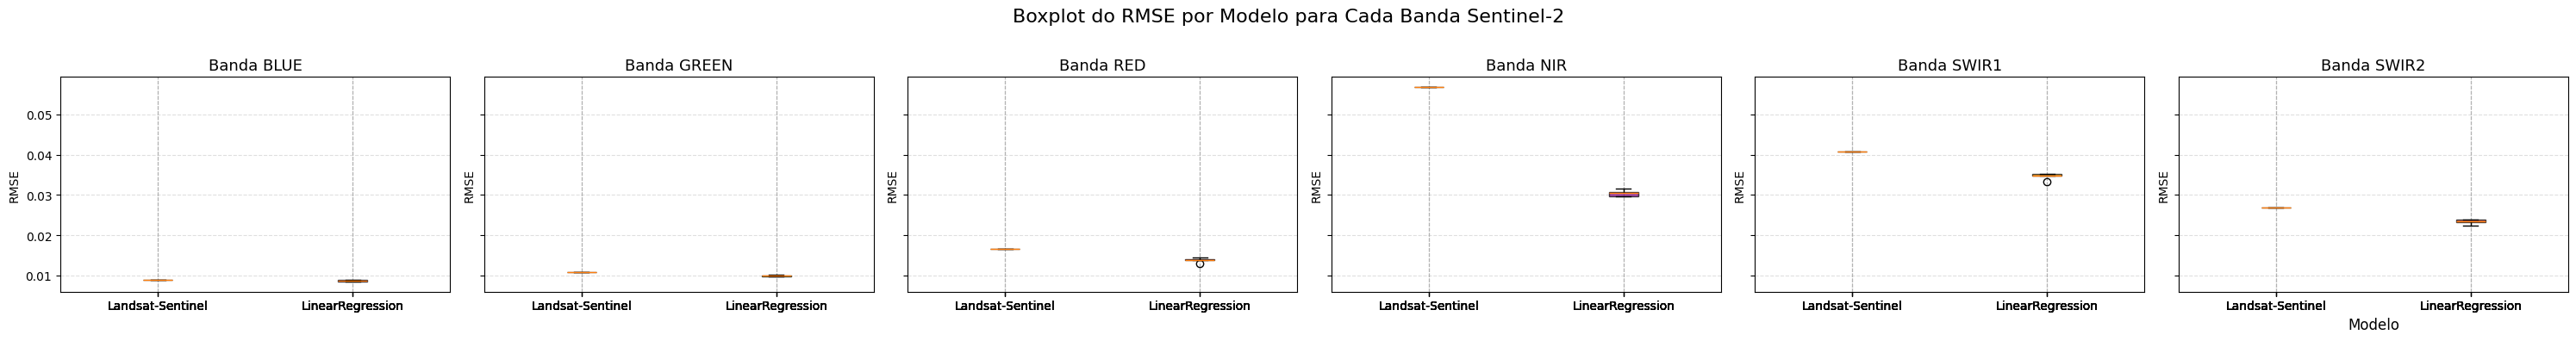

In [10]:
colors = {
    "red": "red",
    "green": "green",
    "blue": "blue",
    "nir": "purple",
    "swir1": "orange",
    "swir2": "brown"
}

bands = common_bands
models = ["Landsat-Sentinel", "LinearRegression"]

fig, axes = plt.subplots(1, len(bands), figsize=(5 * len(bands), 4), sharex=True, sharey=True)

for i, band in enumerate(bands):
    ax = axes[i]
    rmse_values = []

    for model_name in models:
        if model_name == "Landsat-Sentinel":
            y_true = all_results[model_name][band]["y_true"]
            y_pred = all_results[model_name][band]["y_pred"]
            rmse = root_mean_squared_error(y_true, y_pred)
            rmse_values.append([rmse])
        else:
            rmse_vals = metrics_df[
                (metrics_df["model"] == model_name) & (metrics_df["band"] == band)
            ]["rmse"].values
            rmse_values.append(rmse_vals)

    # Plot vertical boxplot: um por modelo
    box = ax.boxplot(
        rmse_values,
        patch_artist=True,
        tick_labels=models
    )

    for patch in box['boxes']:
        patch.set_facecolor(colors[band])
        patch.set_edgecolor('black')
        patch.set_alpha(0.7)

    ax.set_title(f"Banda {band.upper()}", fontsize=13)
    ax.set_ylabel("RMSE")
    ax.grid(True, linestyle="--", alpha=0.4)

axes[-1].set_xlabel("Modelo", fontsize=12)
fig.suptitle("Boxplot do RMSE por Modelo para Cada Banda Sentinel-2", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [11]:
# Bandas de entrada (Landsat)
X_cols = [f"{band}l8" for band in common_bands]
group_col = "indexnum"
n_splits = 5

# Bandas alvo do Sentinel-2
re_bands = ["re1", "re2", "re3", "re4"]
target_cols = [f"{b}s2" for b in re_bands]

# Modelos
model_dict = {
    "LinearRegression": LinearRegression(),
}

# Armazenamento
all_results_re = {}
all_models_re = {}
all_metrics_re = []

for model_name, base_model in tqdm(model_dict.items()):
    all_results_re[model_name] = {}
    all_models_re[model_name] = {}

    for b in re_bands:
        y_col = f"{b}s2"

        X = df[X_cols].astype(np.float32)
        y = df[y_col].astype(np.float32)
        groups = df[group_col]

        kf = GroupKFold(n_splits=n_splits)

        fold_preds = []
        fold_truth = []
        fold_models = []

        for fold, (train_idx, test_idx) in enumerate(kf.split(X, y, groups=groups)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            model = base_model.__class__(**base_model.get_params())
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            fold_preds.append(y_pred)
            fold_truth.append(y_test.to_numpy())
            fold_models.append(model)
            all_metrics_re.append({
                "fold": fold,
                "model": model_name,
                "band": b,
                "r2": r2_score(y_test.to_numpy(), y_pred),
                "mae": mean_absolute_error(y_test.to_numpy(), y_pred),
                "rmse": root_mean_squared_error(y_test.to_numpy(), y_pred)
            })

        all_results_re[model_name][b] = {
            "y_true": np.concatenate(fold_truth),
            "y_pred": np.concatenate(fold_preds)
        }

        all_models_re[model_name][b] = fold_models[-1]

metrics_df_re = pd.DataFrame(all_metrics_re)

100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


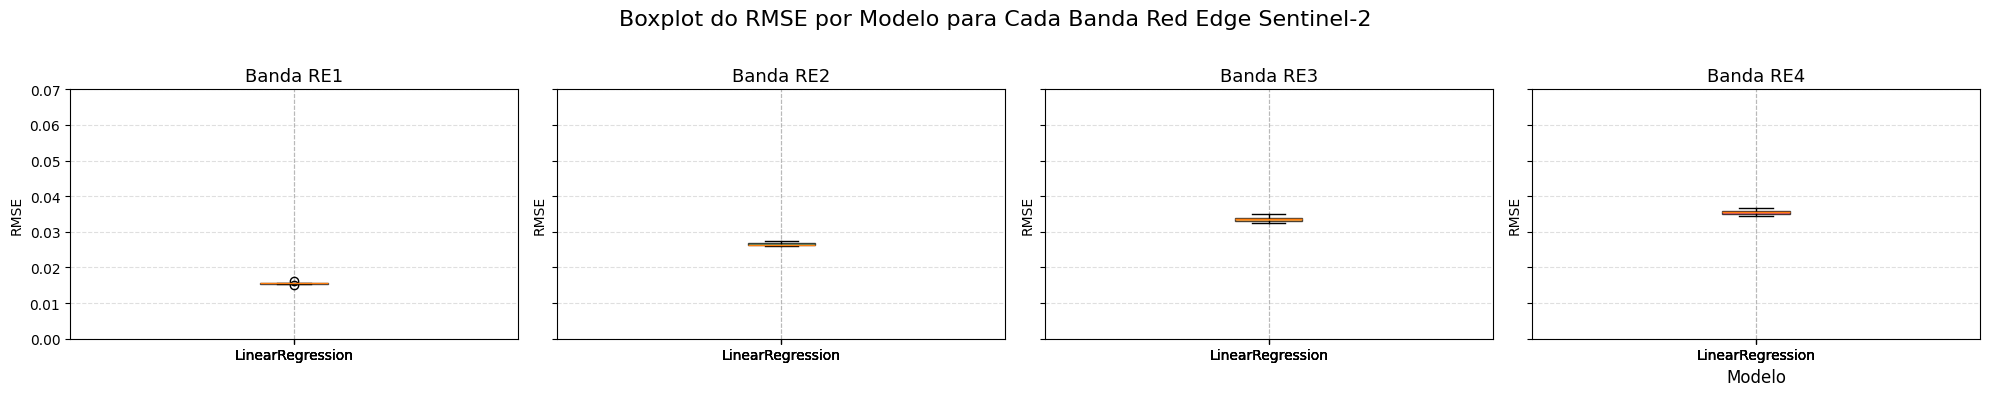

In [12]:
re_bands = ["re1", "re2", "re3", "re4"]
re_colors = {
    "re1": "royalblue",
    "re2": "seagreen",
    "re3": "darkorange",
    "re4": "crimson"
}
models = ["LinearRegression"]

fig, axes = plt.subplots(1, len(re_bands), figsize=(5 * len(re_bands), 4), sharex=True, sharey=True)

for i, band in enumerate(re_bands):
    ax = axes[i]
    rmse_values = []

    for model_name in models:
        rmse_vals = metrics_df_re[
            (metrics_df_re["model"] == model_name) & (metrics_df_re["band"] == band)
        ]["rmse"].values
        rmse_values.append(rmse_vals)

    box = ax.boxplot(
        rmse_values,
        patch_artist=True,
        tick_labels=models
    )

    for patch in box['boxes']:
        patch.set_facecolor(re_colors[band])
        patch.set_edgecolor('black')
        patch.set_alpha(0.7)

    ax.set_title(f"Banda {band.upper()}", fontsize=13)
    ax.set_ylabel("RMSE")
    ax.grid(True, linestyle="--", alpha=0.4)

axes[-1].set_xlabel("Modelo", fontsize=12)
axes[-1].set_ylim(0, 0.07)

fig.suptitle("Boxplot do RMSE por Modelo para Cada Banda Red Edge Sentinel-2", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()